## BGG Recomendation system

 ### Data

In [66]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 217 kB/s 


In [67]:
import numpy as np
import pandas as pd
import math
from google.colab import drive
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

/usr/local/lib/python3.8/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [68]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
bgg_path = "/content/gdrive/MyDrive/все подряд/учеба/магистратура/проектный/bgg.csv"
bgg = pd.read_csv(bgg_path)
bgg = bgg.drop(['Unnamed: 0'], axis=1)
bgg = bgg.sample(frac=1).reset_index().drop(['index'],axis=1)

In [ ]:
bgg

,user,rating,comment,ID,name
0,thattomguy85,7.0,NaN,144553,The Builders: Middle Ages
1,Kilerazn,6.0,The premise isn't new and can be fun really. I...,166384,Spyfall
2,mattwithana,8.0,NaN,198773,Codenames: Pictures
3,satanzzz,8.0,NaN,145014,Cardline: Globetrotter
4,Hadaran,9.5,NaN,527,GIPF
...,...,...,...,...,...
15823264,Sir_Alex,8.0,NaN,144733,Russian Railroads
15823265,ours_des_tavernes,3.0,NaN,200888,Med Sirocco
15823266,steveyz,8.0,Good game. I like the small amount of blocks i...,11886,Texas Glory
15823267,TEFennell4,6.0,NaN,8217,San Juan


In [ ]:
clear_bgg = bgg.drop(['comment'], axis=1)
clear_bgg.rename(columns={'ID': 'gameID', 'user': 'userID', 'name': 'gameName'}, inplace=True)
clear_bgg.head()

,userID,rating,gameID,gameName
0,thattomguy85,7.0,144553,The Builders: Middle Ages
1,Kilerazn,6.0,166384,Spyfall
2,mattwithana,8.0,198773,Codenames: Pictures
3,satanzzz,8.0,145014,Cardline: Globetrotter
4,Hadaran,9.5,527,GIPF


### Exploratory analysis

Распределение числа пользователей по количеству взаимодействий

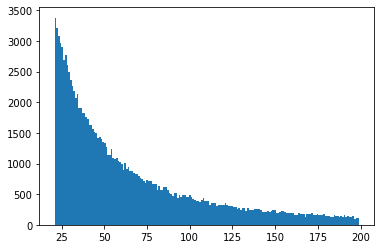

In [ ]:
counter = Counter(clear_bgg['userID'])
values = dict(counter).values()
values_less_100 = [elem for elem in values if 20 < elem < 200]
fig = plt.hist(values_less_100, bins = 179)

Разпределение числа "айтемов" по количеству взаимодействий

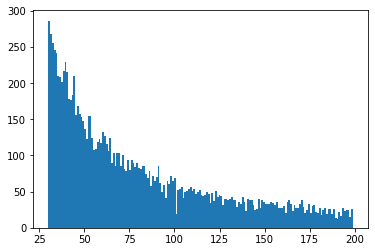

In [ ]:
counter = Counter(clear_bgg['gameID'])
items = dict(counter).values()
items_less_100 = [elem for elem in items if 20 < elem < 200]
fig = plt.hist(items_less_100, bins = 170)

Распределение оценок

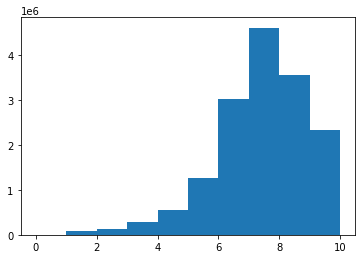

In [ ]:
fig = plt.hist(clear_bgg['rating'])

### Разделение данных на тренировочные и валидационные

Возьмем 1% от всех данных (пока что, потом дольше)

In [ ]:
PERCENT = 10
shape = clear_bgg.shape[0] // (100 // PERCENT)
data = clear_bgg.head(shape)
data

,userID,rating,gameID,gameName
0,thattomguy85,7.0,144553,The Builders: Middle Ages
1,Kilerazn,6.0,166384,Spyfall
2,mattwithana,8.0,198773,Codenames: Pictures
3,satanzzz,8.0,145014,Cardline: Globetrotter
4,Hadaran,9.5,527,GIPF
...,...,...,...,...
1582321,Muller_Alencar,10.0,185123,Ascension: Dreamscape
1582322,le coach,8.0,242302,Space Base
1582323,Jacko9627,6.0,183896,Firefly Fluxx
1582324,handsomeox,7.0,197376,Charterstone


Отрежем всех пользователей голосовавших 10 и менее раз, так как они не несут существенных данных

In [ ]:
MIN_RATE = 20
data_filtered = data.groupby('userID').filter(lambda x: len(x) >= MIN_RATE)
data_filtered.shape

(696012, 4)

In [ ]:
bggsep_path = "/content/gdrive/MyDrive/все подряд/учеба/магистратура/проектный/bggsep.csv"
data_filtered.to_csv(bggsep_path)

In [ ]:
train = pd.DataFrame()
test = pd.DataFrame()
uniques = data_filtered['userID'].unique()
for user in uniques:
    temp_table = data_filtered.loc[data_filtered['userID'] == user]
    cnt = temp_table.shape[0]
    size_train = round(cnt*0.9, 0)
    train = train.append(temp_table.iloc[:int(size_train),:])
    test = test.append(temp_table.iloc[int(size_train):,:])

In [ ]:
print('dataset train', train.shape[0], ' test', test.shape[0])
print('unique user in train', train['userID'].nunique(), 'test ', test['userID'].nunique())
print('cold-user in the test', test['userID'].nunique() - test[test['userID'].isin(train['userID'])]['userID'].nunique())

dataset train 941688  test 101902
unique user in train 43855 test  43855
cold-user in the test 0


In [ ]:
print('unique games in train', train['gameID'].nunique(), 'test', test['gameID'].nunique())
print('cold-item in the test', test['gameID'].nunique() - test[test['gameID'].isin(train['gameID'])]['gameID'].nunique())

unique games in train 18811 test 11674
cold-item in the test 139


In [ ]:
unique_users_train = train['userID'].unique()
unique_users_test = test['userID'].unique()
unique_items_train = train['gameID'].unique()
unique_items_test = test['gameID'].unique()
cold_users = [elem for elem in unique_users_test if elem not in unique_users_train]
cold_items = [elem for elem in unique_items_test if elem not in unique_items_train]

### Коллоборативная фильтрация, используя SVD

In [ ]:
! pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
import os

In [ ]:
train_sup = Dataset.load_from_df(train.iloc[:, :],  reader=Reader(line_format='user item rating'))
test_sup = Dataset.load_from_df(test.iloc[:, :],  reader=Reader(line_format='user item rating'))

In [ ]:
svd = SVD(random_state=0, n_factors=10, n_epochs=30, verbose=True)
train_sup = train_sup.build_full_trainset()
svd.fit(train_sup)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [ ]:
def predict(algo,
            data,
            usercol,
            itemcol,
            predcol):
    predictions = [
        algo.predict(getattr(row, usercol), getattr(row, itemcol))
        for row in data.itertuples()
    ]
    predictions = pd.DataFrame(predictions)
    predictions = predictions.rename(
        index=str, columns={"uid": usercol, "iid": itemcol, "est": predcol}
    )
    return predictions.drop(["details", "r_ui"], axis="columns")

def compute_ranking_predictions(algo,
                                data,
                                usercol,
                                itemcol,
                                predcol,
                                remove_seen=False):
    preds_lst = []
    for user in data[usercol].unique():
        for item in data[itemcol].unique():
            preds_lst.append([user, item, algo.predict(user, item).est])

    all_predictions = pd.DataFrame(data=preds_lst, columns=[usercol, itemcol, predcol])

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions

In [ ]:
predictions = predict(svd, train, usercol='userID', itemcol='gameID', predcol='pred')
predictions.head()

,userID,gameID,pred
0,TomVasel,173156,5
1,TomVasel,18580,5
2,TomVasel,4991,5
3,TomVasel,227789,5
4,TomVasel,21666,5


In [ ]:
all_predictions = compute_ranking_predictions(svd, train, usercol='userID', itemcol='gameID', predcol='pred', remove_seen=True)
all_predictions_final = all_predictions.sort_values(by='pred', ascending=False).groupby(['userID'])['gameID'].apply(lambda x: list(x)).to_frame().reset_index()
all_predictions_final

,userID,gameID
0,AGKorson,"[103649, 209778, 244521, 28720, 230244, 232437..."
1,Abiteacher,"[83040, 204472, 25292, 103877, 782, 4383, 4119..."
2,Adrimetum,"[564, 35865, 23890, 10884, 14812, 43264, 2781,..."
3,Agnieszka Rz1,"[221107, 169513, 46396, 7338, 63161, 135, 1471..."
4,Ajax,"[23812, 233020, 372, 4352, 194229, 88126, 2690..."
...,...,...
913,zetseui,"[15512, 114438, 117959, 171233, 37628, 165986,..."
914,zizishaoye,"[2559, 202732, 187680, 43578, 23550, 55222, 16..."
915,zodball,"[10884, 96602, 227460, 140995, 128780, 258041,..."
916,zumikon,"[281960, 265402, 82955, 116593, 136813, 167270..."


In [ ]:
ranking_df = test.merge(train, on = ['userID', 'gameID'], how='left', suffixes=('', '_TrainRating'))
ranking_df['cold_users'] = ranking_df.userID.map(lambda x: x in cold_users)
ranking_df['cold_items'] = ranking_df.gameID.map(lambda x: x in cold_items)
ranking_df.head()

,userID,rating,gameID,rating_TrainRating,cold_users,cold_items
0,TomVasel,7.0,184372,NaN,False,True
1,TomVasel,8.5,156009,NaN,False,False
2,TomVasel,4.0,166658,NaN,False,True
3,TomVasel,3.0,22861,NaN,False,True
4,Sciurus,7.0,6707,NaN,False,False


In [ ]:
ranking_df.cold_items.value_counts()

False    804
True     312
Name: cold_items, dtype: int64

In [ ]:
ranking_df.cold_users.value_counts()

False    1116
Name: cold_users, dtype: int64

In [ ]:
ranking_df_final = ranking_df[(ranking_df.cold_items==False) & (ranking_df.cold_users==False) & (ranking_df.rating_TrainRating.isnull())]
ranking_df_final = ranking_df_final.groupby(['userID'])['gameID'].apply(lambda x: list(x)).to_frame().reset_index()
ranking_table = ranking_df_final.merge(all_predictions_final, on = ['userID'], 
                                       how='left', suffixes=('_gt', '_pred'))
ranking_table.head()

,userID,gameID_gt,gameID_pred
0,AGKorson,[195867],"[103649, 209778, 244521, 28720, 230244, 232437..."
1,Adrimetum,[13004],"[564, 35865, 23890, 10884, 14812, 43264, 2781,..."
2,Agnieszka Rz1,[117959],"[221107, 169513, 46396, 7338, 63161, 135, 1471..."
3,Ajax,[164698],"[23812, 233020, 372, 4352, 194229, 88126, 2690..."
4,Alan How,"[3243, 841]","[163968, 207207, 17329, 191512, 225316, 177736..."


In [ ]:
ranking_table['top_3'] = ranking_table.apply(lambda x: [int(pred in x.gameID_gt) for pred in x.gameID_pred[:3]], axis=1)
ranking_table['top_5'] = ranking_table.apply(lambda x: [int(pred in x.gameID_gt) for pred in x.gameID_pred[:5]], axis=1)
ranking_table['top_10'] = ranking_table.apply(lambda x: [int(pred in x.gameID_gt) for pred in x.gameID_pred[:10]], axis=1)
ranking_table.head()

,userID,gameID_gt,gameID_pred,top_3,top_5,top_10
0,AGKorson,[195867],"[103649, 209778, 244521, 28720, 230244, 232437...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Adrimetum,[13004],"[564, 35865, 23890, 10884, 14812, 43264, 2781,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Agnieszka Rz1,[117959],"[221107, 169513, 46396, 7338, 63161, 135, 1471...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Ajax,[164698],"[23812, 233020, 372, 4352, 194229, 88126, 2690...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Alan How,"[3243, 841]","[163968, 207207, 17329, 191512, 225316, 177736...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


### Metrics

Введем метрики для оценки качества алгоритма ранжирования. Будем использовать MRR (Mean reciprocal rank) и MAP@K (Mean average precision at K). Но в остновном смотрим на MAP@K, так как она самая популярная из всех.

In [ ]:
def mean_reciprocal_rank(rs):
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [ ]:
score_results_svd = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K'])
for top in [3, 5, 10]:
    score_results_svd.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)].values))
    score_results_svd.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)].values))
score_results_svd

NameError: ignored

In [ ]:
data

,Unnamed: 0,userID,rating,gameID
0,15713609,Brakus,6.0,Tokyo Highway
1,6673459,jonnymut,8.5,Keythedral
2,226413,Agamon,7.5,Red7
3,6078474,sszy59,8.0,Era: Medieval Age
4,9338196,Mibao,8.2,Rococo
...,...,...,...,...
189730,2348920,Strikeforce007,7.0,Darkrock Ventures
189731,5256213,damaloch,1.0,Game of Goose
189732,13893513,GaryP,6.0,Nusfjord
189733,9218882,brusty,7.0,Scythe


### Коллоборативная фильтрация, используя ALS

In [ ]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

/usr/local/lib/python3.8/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
id2user = {key: value for key, value in enumerate(train.userID.unique())}
id2items = {key: value for key, value in enumerate(train.gameID.unique())}
rating = list(train.rating)

user2id  = {value:key for key, value in id2user.items()}
items2id  = {value:key for key, value in id2items.items()}

rows = train.userID.map(user2id)
cols = train.gameID.map(items2id)

rating_sparse = csr_matrix((rating, (rows, cols)), shape=(len(user2id), len(items2id)))
rating_sparse

<43855x18811 sparse matrix of type '<class 'numpy.float64'>'
	with 941688 stored elements in Compressed Sparse Row format>

In [ ]:
rating_sparse.toarray()

array([[ 6., 10.,  7., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  8., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
ALS = AlternatingLeastSquares()
ALS.fit(rating_sparse)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
predict = ALS.recommend_all(rating_sparse, filter_already_liked_items=True)

In [ ]:
print(predict.shape)
predict

(43855, 10)


array([[ 229,   51, 2787, ...,  266, 1060, 1110],
       [ 261,   13,  423, ..., 2554,  514,  132],
       [1761, 1012, 1077, ...,  806, 2620,  215],
       ...,
       [  60, 2122, 1448, ..., 2593, 2183,  112],
       [ 896,    3,  817, ..., 1483, 1008,  861],
       [1214, 1112, 2564, ...,   16,  975, 1745]], dtype=int32)

In [ ]:
test['cold_users'] = test.userID.map(lambda x: x in cold_users)
test['cold_items'] = test.gameID.map(lambda x: x in cold_items)

In [ ]:
test_result = test[(test.cold_items==False)&(test.cold_users==False)]
test_result = test_result.groupby(['userID'])['gameID'].apply(lambda x: list(x)).reset_index()
test_result['gameID_pred'] = test_result.userID.map(lambda x: predict[user2id[x], :])
test_result['gameID_pred'] = test_result.gameID_pred.map(lambda x: [id2items[i] for i in x])
test_result.head()

,userID,gameID,gameID_pred
0,-=Yod@=-,"[22192, 2162]","[37111, 6249, 93, 181304, 115746, 54, 177736, ..."
1,-Johnny-,"[173341, 122522, 68448, 2083]","[54, 39463, 2511, 8217, 5, 8203, 158899, 26990..."
2,-mIDE-,"[102794, 327, 5894, 24480]","[118048, 77423, 45315, 118, 9674, 183394, 6842..."
3,-toni-,"[51, 16986]","[62219, 9220, 70323, 13, 34635, 98778, 11, 478..."
4,...Hammer,[22897],"[15062, 28720, 150376, 183394, 25292, 70919, 5..."


In [ ]:
test_result['top_3'] = test_result.apply(lambda x: [int(pred in x.gameID_pred[:3]) for pred in x.gameID[:3]], axis=1)
test_result['top_5'] = test_result.apply(lambda x: [int(pred in x.gameID_pred[:5]) for pred in x.gameID[:5]], axis=1)
test_result['top_10'] = test_result.apply(lambda x: [int(pred in x.gameID_pred[:10]) for pred in x.gameID[:10]], axis=1)

In [ ]:
test_result.head(10)

,userID,gameID,gameID_pred,top_3,top_5,top_10
0,-=Yod@=-,"[22192, 2162]","[37111, 6249, 93, 181304, 115746, 54, 177736, ...","[0, 0]","[0, 0]","[0, 0]"
1,-Johnny-,"[173341, 122522, 68448, 2083]","[54, 39463, 2511, 8217, 5, 8203, 158899, 26990...","[0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]"
2,-mIDE-,"[102794, 327, 5894, 24480]","[118048, 77423, 45315, 118, 9674, 183394, 6842...","[0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]"
3,-toni-,"[51, 16986]","[62219, 9220, 70323, 13, 34635, 98778, 11, 478...","[0, 0]","[0, 0]","[0, 0]"
4,...Hammer,[22897],"[15062, 28720, 150376, 183394, 25292, 70919, 5...",[0],[0],[0]
5,.JcK.,"[438, 7805]","[193738, 9609, 42, 121921, 30549, 10, 29368, 2...","[0, 0]","[0, 0]","[0, 0]"
6,00vito,"[39463, 102548]","[30549, 163412, 50, 93, 62219, 209685, 172, 25...","[0, 0]","[0, 0]","[0, 0]"
7,0492372665,"[165401, 102680]","[103343, 161970, 157969, 171, 102680, 129622, ...","[0, 0]","[0, 1]","[0, 1]"
8,07734,[167355],"[50, 42, 156129, 41114, 22345, 30549, 432, 245...",[0],[0],[0]
9,0815Spieler,"[172547, 157526]","[224517, 169786, 170216, 188834, 9220, 138161,...","[0, 0]","[0, 0]","[0, 0]"


In [ ]:
score_results_als = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K'])

In [ ]:
for top in [3, 5, 10]:
    score_results_als.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(test_result['top_'+str(top)].values))
    score_results_als.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(test_result['top_'+str(top)].values))

In [ ]:
score_results_als

,MRR,MAP@K
top_3,0.011477,0.011477
top_5,0.019119,0.019123
top_10,0.034304,0.034329


### Предложение самых популярных

In [ ]:
list(train.groupby('gameID')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)['gameID'][:10].values)

[172493, 206940, 40561, 176435, 4228, 285157, 34496, 96157, 209511, 187617]

In [ ]:
ranking_table['most_popular'] = 1
ranking_table['most_popular'] = ranking_table['most_popular'].map(lambda x: list(train.groupby('gameID')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)['gameID'][:10].values))
ranking_table.head()

,userID,gameID_gt,gameID_pred,top_3,top_5,top_10,most_popular
0,AGKorson,[195867],"[103649, 209778, 244521, 28720, 230244, 232437...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[172493, 206940, 40561, 176435, 4228, 285157, ..."
1,Adrimetum,[13004],"[564, 35865, 23890, 10884, 14812, 43264, 2781,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[172493, 206940, 40561, 176435, 4228, 285157, ..."
2,Agnieszka Rz1,[117959],"[221107, 169513, 46396, 7338, 63161, 135, 1471...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[172493, 206940, 40561, 176435, 4228, 285157, ..."
3,Ajax,[164698],"[23812, 233020, 372, 4352, 194229, 88126, 2690...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[172493, 206940, 40561, 176435, 4228, 285157, ..."
4,Alan How,"[3243, 841]","[163968, 207207, 17329, 191512, 225316, 177736...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[172493, 206940, 40561, 176435, 4228, 285157, ..."


In [ ]:
ranking_table['top_3_mp'] = ranking_table.apply(lambda x: [int(pred in x.gameID_gt) for pred in x.most_popular[:3]], axis=1)
ranking_table['top_5_mp'] = ranking_table.apply(lambda x: [int(pred in x.gameID_gt) for pred in x.most_popular[:5]], axis=1)
ranking_table['top_10_mp'] = ranking_table.apply(lambda x: [int(pred in x.gameID_gt) for pred in x.most_popular[:10]], axis=1)

In [ ]:
score_results_mp = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K'])

In [ ]:
for top in [3, 5, 10]:
    score_results_mp.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)+'_mp'].values))
    score_results_mp.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)+'_mp'].values))

In [ ]:
score_results_mp

,MRR,MAP@K
top_3,0.0,0.0
top_5,0.0,0.0
top_10,0.0,0.0


### Получение данных с bgg через xml

In [78]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import requests
import xmltodict

def get_rating_from_bgg(username):
    url = f'https://boardgamegeek.com/xmlapi2/collection?username={username}'
    items = None
    for i in range(10):
        response = requests.get(url)
        data = xmltodict.parse(response.content)
        if 'items' in data.keys():
            items = data['items']['item']
            break

    if not items:
        return None

    result_dict = {}
    for item in items:
        game_id = item['@objectid']
        if 'stats' in item.keys():
            stats = item['stats']
            if 'rating' in stats.keys():
                rating = stats['rating']
                if '@value' in rating.keys():
                    value = rating['@value']
                    try:
                        value_float = float(value)
                        result_dict[game_id] = value_float
                    except Exception as ex:
                        pass

    bgg_user_list = [(username, rating, game_id) for game_id, rating in result_dict.items()]
    result_df = pd.DataFrame(bgg_user_list, columns=['userID', 'rating', 'gameID'])
    
    return result_df
  
username = 's1zday'
get_rating_from_bgg(username)

,userID,rating,gameID
0,s1zday,8.0,233247
1,s1zday,6.0,180024
2,s1zday,5.5,432
3,s1zday,9.0,173346
4,s1zday,5.0,3818
...,...,...,...
116,s1zday,7.0,297864
117,s1zday,7.0,266444
118,s1zday,7.0,247436
119,s1zday,6.5,274128


### Получение данных bgg через csv

In [123]:
import requests
from io import StringIO
import pandas as pd
from time import sleep


def get_rating_from_bgg_csv(username):
  for _ in range(5):
    try:
      url = f"https://boardgamegeek.com/geekcollection.php?action=exportcsv&subtype=boardgame&username={username}&all=1&exporttype=csv"
      r = requests.get(url)
      content = r.content.decode()
      csvStringIO = StringIO(content)
      df = pd.read_csv(csvStringIO, sep=",", header=0)
      short_df = df[['objectid', 'rating']]     
      short_df = short_df.rename(columns={'objectid': 'gameID'})
      short_df.insert(0, "userID", username)
      return short_df
    except:
      sleep(1)
  return None

username = 's1zday'
user_df = get_rating_from_bgg_csv(username)
if df is None:
  print('none')
user_df

,userID,gameID,rating
0,s1zday,233247,8.0
1,s1zday,180024,6.0
2,s1zday,432,5.5
3,s1zday,173346,9.0
4,s1zday,3818,5.0
...,...,...,...
117,s1zday,297864,7.0
118,s1zday,266444,7.0
119,s1zday,247436,7.0
120,s1zday,274128,6.5


### Сохранение модели

In [69]:
bggsep_path = "/content/gdrive/MyDrive/все подряд/учеба/магистратура/проектный/bggsep.csv"
data_export = pd.read_csv(bggsep_path)
data_export = data_export.drop(['Unnamed: 0'], axis=1)

In [122]:
username = 'gortor'
result_dict = get_rating_from_bgg(username)
data = pd.concat([data_export, user_df])

In [124]:
data

,userID,rating,gameID,gameName
0,satanzzz,8.0,145014,Cardline: Globetrotter
1,BinkFloyd,8.0,161614,Stockpile
2,mkasser,9.0,30549,Pandemic
3,warta,7.0,13230,Gobblet Gobblers
4,stebourd,9.0,40834,Dominion: Intrigue
...,...,...,...,...
24,gortor,6.5,77130,NaN
25,gortor,0.0,274795,NaN
26,gortor,8.0,264220,NaN
27,gortor,0.0,267325,NaN


In [125]:
unique_users = data['userID'].unique()
unique_items = data['gameID'].unique()
id2user = {key: value for key, value in enumerate(unique_users)}
id2items = {key: value for key, value in enumerate(unique_items)}
rating = list(data.rating)

user2id  = {value:key for key, value in id2user.items()}
items2id  = {value:key for key, value in id2items.items()}

rows = data.userID.map(user2id)
cols = data.gameID.map(items2id)

rating_sparse = csr_matrix((rating, (rows, cols)), shape=(len(user2id), len(items2id)))
rating_sparse.toarray()

array([[8., 0., 0., ..., 0., 0., 0.],
       [0., 8., 0., ..., 0., 0., 0.],
       [0., 0., 9., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
ALS = AlternatingLeastSquares()
ALS.fit(rating_sparse)

  0%|          | 0/15 [00:00<?, ?it/s]

In [127]:
import pickle

In [128]:
with open('model.pickle', 'wb') as handle:
    pickle.dump(ALS, handle)

In [129]:
with open('model.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [140]:
predict = model.recommend_all(rating_sparse, filter_already_liked_items=True)

In [166]:
test_result = data.groupby(['userID'])['gameID'].apply(lambda x: list(x)).reset_index()
test_result['gameID_pred'] = test_result.userID.map(lambda x: predict[user2id[x], :])
test_result['gameID_pred'] = test_result.gameID_pred.map(lambda x: [id2items[i] for i in x])
test_result.head()

,userID,gameID,gameID_pred
0,-=Yod@=-,"[24480, 257501, 67436, 216094, 90137, 40834, 9...","[66188, 173346, 12333, 70919, 463, 129622, 172..."
1,-Johnny-,"[69851, 152, 29411, 61692, 2394, 39351, 10383,...","[126163, 15062, 54625, 167791, 16992, 475, 915..."
2,-mIDE-,"[4792, 67436, 28723, 174430, 21441, 32441, 221...","[24508, 555, 12, 113294, 25417, 209685, 394, 4..."
3,-toni-,"[4390, 66, 13089, 158100, 25669, 130006, 555, ...","[9217, 98778, 171131, 178900, 230802, 1927, 32..."
4,.JcK.,"[22684, 3421, 3, 37904, 45315, 278, 11170, 109...","[27588, 2655, 18602, 9674, 38453, 2653, 37111,..."


In [181]:
userids = np.arange(rating_sparse.shape[0])
predict_games, predict_percents = model.recommend(userids, rating_sparse, filter_already_liked_items=True, N=10)

In [186]:
user_pred = [id2items[i] for i in predict_games[user2id[username], :]]
user_pred_percents = predict_percents[user2id[username], :]

result = {}
for num, game_id in enumerate(user_pred):
    game_name = data[data.gameID == game_id].iloc[0].gameName
    percent = round(user_pred_percents[num] * 100, 2)
    result.update({game_name: percent})

result

{'Rising Sun': 55.9,
 'Galaxy Trucker': 46.6,
 'Coup': 42.21,
 'Gloomhaven': 41.01,
 'Codenames': 36.89,
 'Kemet': 35.15,
 'Battlestar Galactica: The Board Game': 33.25,
 'Libertalia': 33.08,
 'Arboretum': 31.06,
 'The Gallerist': 30.53}